# Model Fitting with Astropy (non-Bayesian)

Given data, we can find the best-fit model using a range of different methods. Astropy has some nice functionality to perform such fits so long as your model is composed of supported distributions.

We will walk through their tutorial on fitting 1D data:
<a href="https://docs.astropy.org/en/stable/modeling/fitting.html">Fitting with Astropy</a>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

1. Make mock data.

Text(0, 0.5, 'y')

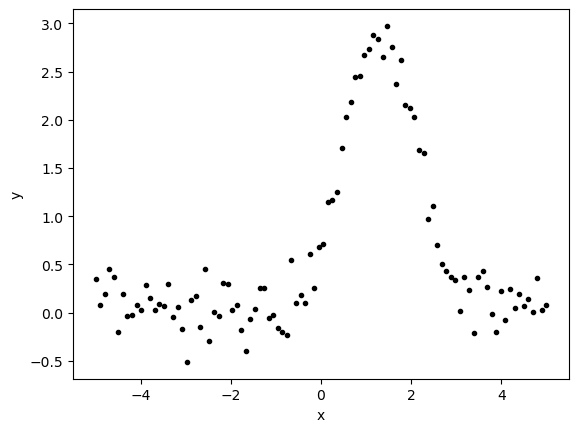

In [69]:
# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 100)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

plt.figure()
plt.plot(x, y, 'k.')
plt.xlabel('x')
plt.ylabel('y')

2. Fit the data using a box model.

In [70]:
# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Trapezoid1D(amplitude=1., x_0=1., width=1., slope=0.5,
                            bounds={"x_0": (-5., 5.)})
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)

3. Fit the same data using a Gaussian model.

In [71]:
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

4. Visualize results

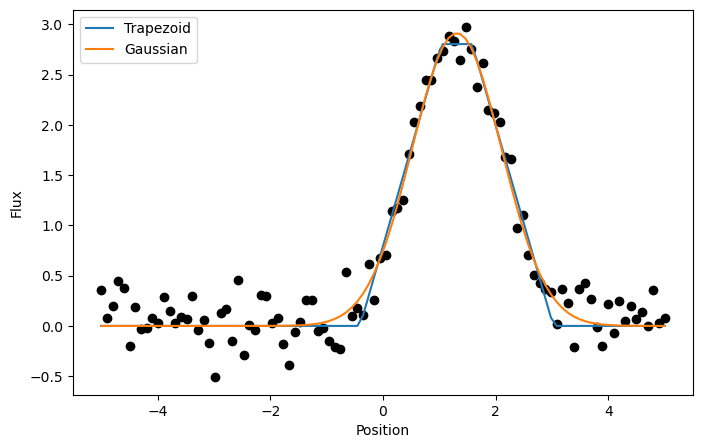

In [72]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, t(x), label='Trapezoid')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)

(-0.6, 0.6)

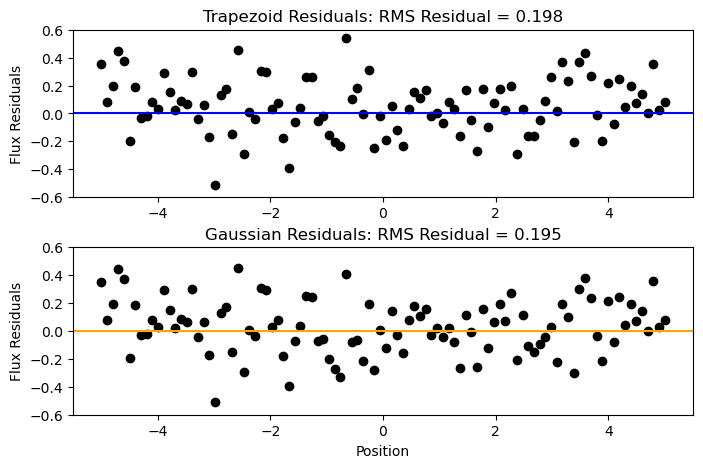

In [73]:
res_t = np.std(y-t(x))
res_g = np.std(y-g(x))

# Plot the residuals from the best-fit model
plt.figure(figsize=(8,5))
plt.subplot(211)
plt.subplots_adjust(hspace=0.3)

plt.plot(x, y-t(x), 'ko')
plt.axhline(0, color='blue')
plt.ylabel('Flux Residuals')
plt.title(f'Trapezoid Residuals: RMS Residual = {res_t:.3f}')
plt.ylim(-0.6, 0.6)

plt.subplot(212)
plt.plot(x, y-g(x), 'ko')
plt.axhline(0, color='orange')
plt.xlabel('Position')
plt.ylabel('Flux Residuals')
plt.title(f'Gaussian Residuals: RMS Residual = {res_g:.3f}')
plt.ylim(-0.6, 0.6)

5. Parameter error estimattion

In [74]:
# Fit the data using a Gaussian
fit_ge = fitting.LevMarLSQFitter(calc_uncertainties=True)
ge = fit_ge(g_init, x, y)
cov = fit_ge.fit_info['param_cov']
err = np.sqrt(np.diag(cov))

val_dict = dict(zip(ge.param_names, ge.parameters))
err_dict = dict(zip(ge.param_names, np.diag(cov)**0.5))

print('** Fit Results **')
for param in ge.param_names:
    print(f"{param:15s} {val_dict[param]:.3f} +/- {err_dict[param]:.3f}")

** Fit Results **
amplitude       2.914 +/- 0.066
mean            1.309 +/- 0.021
stddev          0.792 +/- 0.021


6. Visualize the model uncertainties:

(although see this <a href="https://gist.github.com/eteq/1f3f0cec9e4f27536d52cd59054c55f2">nice tutorial</a> for a superior Monte Carlo sampling technique to get error curves).

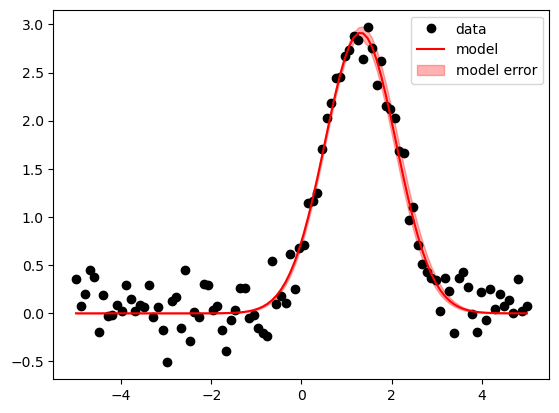

In [75]:
ge_up = ge.copy()
ge_down = ge.copy()

for i, nm in enumerate(ge.param_names):
    setattr(ge_up, nm, getattr(ge, nm) + fit_ge.fit_info['param_cov'][i, i]**0.5)
    setattr(ge_down, nm, getattr(ge, nm) - fit_ge.fit_info['param_cov'][i, i]**0.5)
    
plt.plot(x, y, 'ko', label='data')
plt.plot(x, ge(x), 'r', label='model')
plt.fill_between(x, ge_up(x), ge_down(x), color='red', label='model error', alpha=0.3)
plt.legend(loc=0)